### Imports

In [1]:
import numpy as np
import colorsys
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from PIL import Image
import biotuner
from biotuner.biotuner_utils import *
from biotuner.biotuner_object import *
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)


pygame 2.1.2 (SDL 2.0.18, Python 3.8.15)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Biowavelenght

'''
    == A few notes about color ==

    Color   Wavelength(nm) Frequency(THz)
    Red     620-750        484-400
    Orange  590-620        508-484
    Yellow  570-590        526-508
    Green   495-570        606-526
    Blue    450-495        668-606
    Violet  380-450        789-668

    f is frequency (cycles per second)
    l (lambda) is wavelength (meters per cycle)
    e is energy (Joules)
    h (Plank's constant) = 6.6260695729 x 10^-34 Joule*seconds
                         = 6.6260695729 x 10^-34 m^2*kg/seconds
    c = 299792458 meters per second
    f = c/l
    l = c/f
    e = h*f
    e = c*h/l

    List of peak frequency responses for each type of 
    photoreceptor cell in the human eye:
        S cone: 437 nm
        M cone: 533 nm
        L cone: 564 nm
        rod:    550 nm in bright daylight, 498 nm when dark adapted. 
                Rods adapt to low light conditions by becoming more sensitive.
                Peak frequency response shifts to 498 nm.


A few lines about astronomical spectroscopy.



'''

### EEG spectral peaks to color palette

In [2]:
import time
#from biotuner_object import *
data = np.load('data_examples/EEG_pareidolia/parei_data_1000ts.npy')
start = time.time()
biotuning = compute_biotuner(1000, peaks_function = 'EMD', precision = 0.1, n_harm = 10,
                    ratios_n_harms = 10, ratios_inc_fit = False, ratios_inc = False) # Initialize biotuner object
biotuning.peaks_extraction(data[100], ratios_extension = True, max_freq = 50)
_, _, _ = biotuning.peaks_extension(method = 'harmonic_fit', harm_function = 'mult', cons_limit = 0.1)

Number of peaks : 5
Number of extended peaks :  7


c:\Users\User\anaconda3\envs\biotuner\lib\site-packages\scipy\signal\_spectral_py.py:1999: UserWarning: nperseg = 10000 is greater than input length  = 9501, using nperseg = 9501
  warnings.warn('nperseg = {0:d} is greater than input length '


### Evolution of color palettes from multiple successive time series

Number of peaks : 5
Number of peaks : 5
Number of peaks : 5
Number of peaks : 5


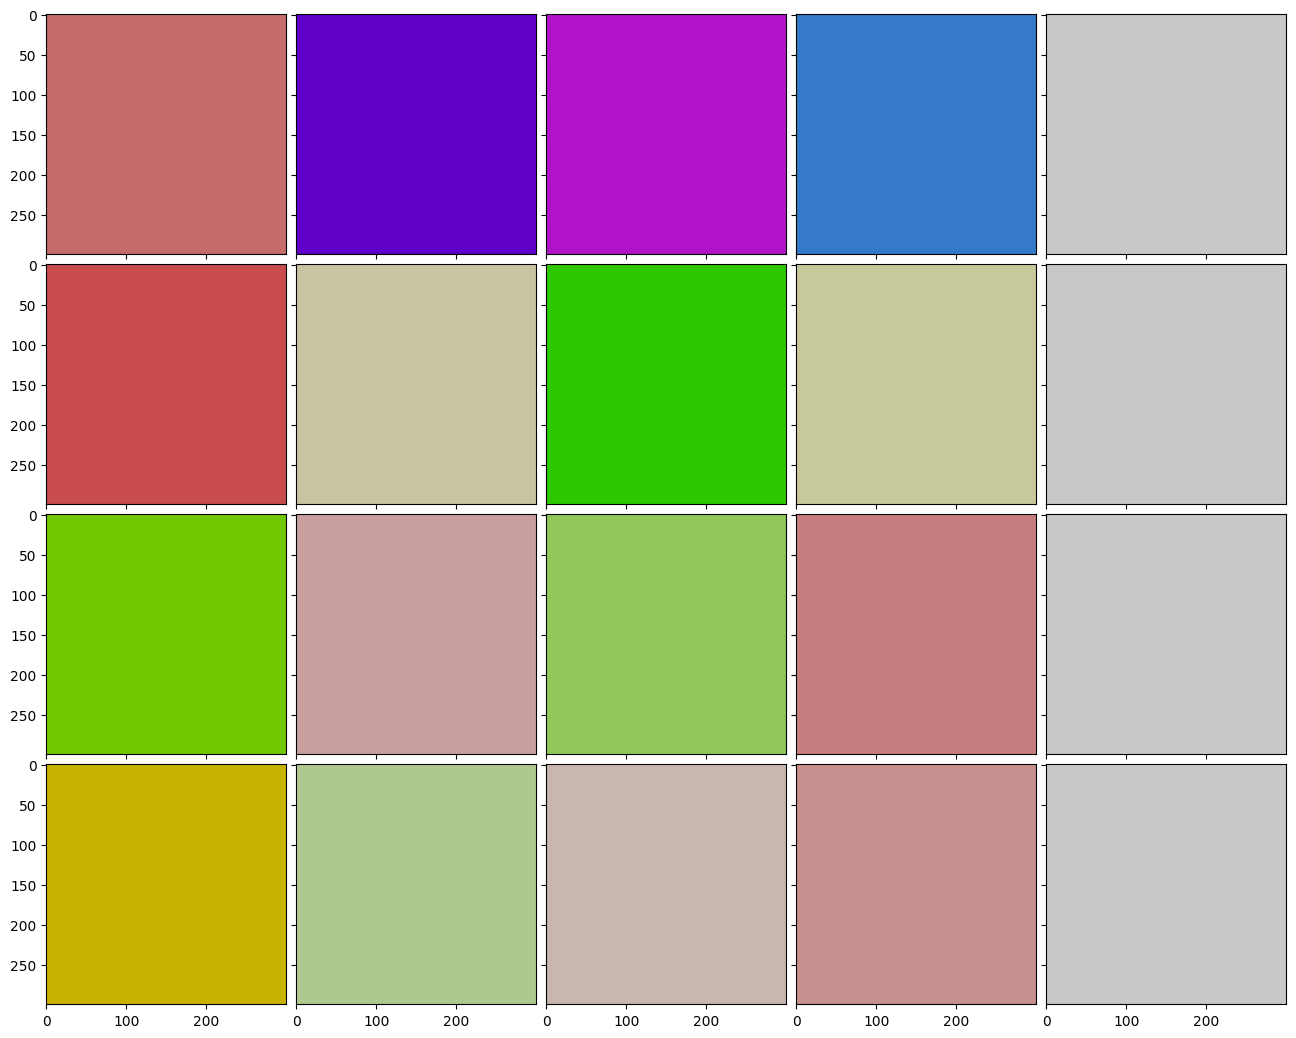

In [4]:
from biotuner.biocolors import scale2freqs, audible2visible, wavelength_to_rgb
tmin = 0
tmax = 5000
window = 1000

timestamps = list(range(tmin, tmax, window))
peaks_tot = []
amps_tot = []
for t in range(len(timestamps)):
    try:
        win = [timestamps[t], timestamps[t+1]] 
        #print(win[0], win[1])
        data_ = data[10][win[0]:win[1]] # Define data (single time series)
        biotuning = compute_biotuner(1000, peaks_function = 'EMD', precision = 0.1, n_harm = 10,
                    ratios_n_harms = 10, ratios_inc_fit = False, ratios_inc = False) # Initialize biotuner object
        biotuning.peaks_extraction(data_, ratios_extension = True, max_freq = 50)
        peaks = list(biotuning.peaks)
        amps = np.array(list(biotuning.amps))
        amps = np.interp(amps, (amps.min(), amps.max()), (75, 175)).astype('uint8')
        peaks_tot.append(peaks)
        amps_tot.append(amps)
    except:
        pass
    
amps_tot
amps_tot = ((amps_tot - np.min(amps_tot)) * (1/(np.max(amps_tot) - np.min(amps_tot)) * 255)).astype('uint8')    
img_array = []
for ts, amp in zip(peaks_tot, amps_tot):
    #print(ts_n)
    peaks = ts
    i = 0
    for p, a in zip(peaks, amp):

        _, _, nm, octave = audible2visible(p)
        #print(octave)
        rgb = wavelength_to_rgb(nm)
        hsv = colorsys.rgb_to_hsv(rgb[0]/float(255),rgb[1]/float(255), rgb[2]/float(255))
        hsv = np.array(hsv)
        hsv = ((hsv - 0) * (1/(1 - 0) * 255)).astype('uint8')
        hsv = list(hsv)
        
        hsv[2] = 200
        hsv[1] = a
        hsv = tuple(hsv)
        img = Image.new('HSV', (300, 300), hsv)
        
        img_array.append(img)


        
fig = plt.figure(figsize=(16., 16.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(len(peaks_tot), len(peaks_tot[0])),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, img_array):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

plt.show()

### Biotuning to color palette

In this example, we will use a tuning to derive a color palette. To do so, we will create a function that takes a scale as input and derives **hue**, **saturation** and **luminance** values. We derive a set of frequencies from the scale. Then, the **hue** corresponds to the frequency value shifted in the visible spectrum range. The **saturation** corresponds to the averaged harmonicity between the scale step and all the other scale steps. Finally, the **luminance** is set to a constant, but there could be ways to derive luminance based on other aspects of the scale strucure. 

In [5]:
from biotuner.metrics import tuning_cons_matrix

def viz_scale_colors(scale, fund, title=None):
    # set default title
    if title == None:
        title = 'Color palette derived from biological tuning'
    min_ = 0
    max_ = 1
    # convert the scale to frequency values
    scale_freqs = scale2freqs(scale, fund)
    # compute the averaged consonance of each step
    scale_cons, _ = tuning_cons_matrix(scale, dyad_similarity, ratio_type='all')
    # rescale to match RGB standards (0, 255)
    scale_cons = ((np.array(scale_cons) - min_) * (1/max_ - min_) * 255).astype('uint8')
    img_array = []
    hsv_all = []
    for s, cons in zip(scale_freqs, scale_cons):
        # convert freq in nanometer values
        _, _, nm, octave = audible2visible(s)
        # convert to RGB values
        rgb = wavelength_to_rgb(nm)
        # convert to HSV values
        hsv = colorsys.rgb_to_hsv(rgb[0]/float(255),rgb[1]/float(255), rgb[2]/float(255))
        hsv = np.array(hsv)
        # rescale
        hsv = ((hsv - 0) * (1/(1 - 0) * 255)).astype('uint8')
        hsv = list(hsv)
        # define the saturation
        hsv[1] = int(cons)
        # define the luminance
        hsv[2] = 200
        hsv = tuple(hsv)
        hsv_all.append(hsv)
        img = Image.new('HSV', (300, 300), hsv)
        img_array.append(img)

    # Figure parameters
    fig = plt.figure(figsize=(16., 16.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                    nrows_ncols=(2, int(len(scale_freqs)/2)),  # creates 2x2 grid of axes
                    axes_pad=0.1,  # pad between axes in inch.
                    )
    for ax, im in zip(grid, img_array):
        # Iterating over the grid returns the Axes.
        ax.imshow(im)
    plt.show()
    return hsv_all

Number of peaks : 5
Number of extended peaks :  13


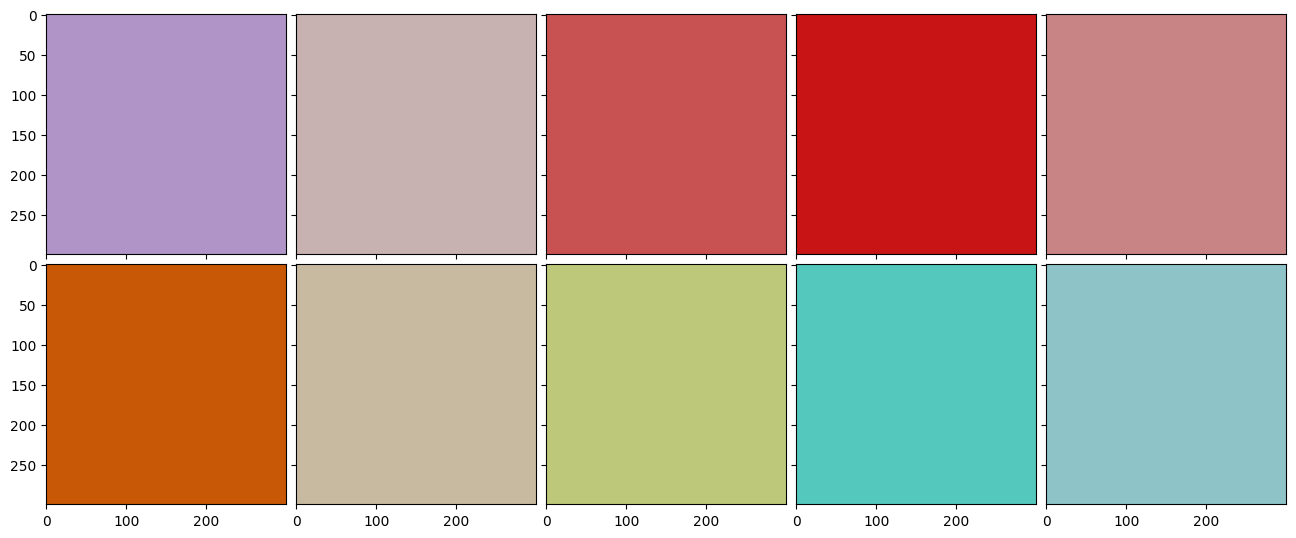

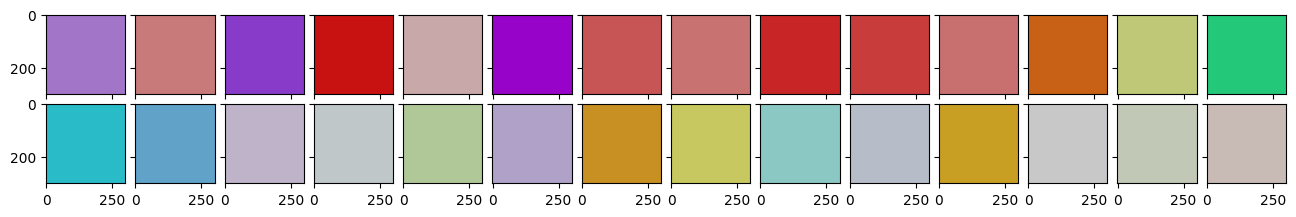

In [7]:
# choose a single time series
data_ = data[37]

# Initialize biotuner object
biotuning = compute_biotuner(1000, peaks_function = 'EMD', precision = 0.1, n_harm = 30,
                    ratios_n_harms = 10, ratios_inc_fit = False, ratios_inc = False) 

# Extract spectral peaks
biotuning.peaks_extraction(data_, max_freq = 50)

# Extend spectral peaks based on interharmonic concordance
biotuning.peaks_extension(method = 'harmonic_fit',
                          harm_function = 'mult', cons_limit = 0.1)

# Take the scales from peaks ratios and extended peaks ratios
scale1 = [1]+biotuning.peaks_ratios
scale2 = [1]+biotuning.extended_peaks_ratios

# Visualize the color palette associated with the scales
hsv1 = viz_scale_colors(scale1, fund = biotuning.peaks[0])
hsv2 = viz_scale_colors(scale2, fund = biotuning.extended_peaks[0])

### Animation of brain color palette

In [ ]:
from biotuner.biocolors import animate_colors

# rescale HSV colors between 0 and 1
hsv_scaled = []
for h in hsv1:
    hsv_scaled.append([x / 255.0 for x in h])

# create animation
animate_colors(hsv_scaled, 10, 60, filename='braincolors')



![SegmentLocal](braincolors.gif "segment")

In [ ]:
import colorsys

def viz_hsv(hsv):
    for h in hsv:
        print(h)
        img = Image.new('HSV', (300, 300), h)
        img_array.append(img)

    # Figure parameters
    fig = plt.figure(figsize=(16., 16.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                    nrows_ncols=(2, int(len(hsv)/2)),  # creates 2x2 grid of axes
                    axes_pad=0.1,  # pad between axes in inch.
                    )
    for ax, im in zip(grid, img_array):
        # Iterating over the grid returns the Axes.
        ax.imshow(im)
    plt.show()
    return


def find_complementary(hsv):
    h, s, v = hsv
    h += 0.5
    if h > 1:
        h -= 1
    return (h, s, v)

def find_triadic(hsv):
    h, s, v = hsv
    h1 = h + 0.33
    h2 = h - 0.33
    if h1 > 1:
        h1 -= 1
    if h2 < 0:
        h2 += 1
    return [(h1, s, v), (h2, s, v)]

def hsv_colors(colors):
    complements = []
    triads = []
    for color in colors:
        h, s, v = color
        complements.append(find_complementary(color))
        triads.append(find_triadic(color))
    return complements, triads

colors = [(0.1, 0.5, 0.6), (0.8, 0.3, 0.7), (0.2, 0.8, 0.9)]
complements, triads = hsv_colors(colors)
print("Complementary Colors:", complements)
print("Triadic Colors:", triads)


Complementary Colors: [(0.6, 0.5, 0.6), (0.30000000000000004, 0.3, 0.7), (0.7, 0.8, 0.9)]
Triadic Colors: [[(0.43000000000000005, 0.5, 0.6), (0.77, 0.5, 0.6)], [(0.13000000000000012, 0.3, 0.7), (0.47000000000000003, 0.3, 0.7)], [(0.53, 0.8, 0.9), (0.87, 0.8, 0.9)]]


In [ ]:
import colorsys

def find_complementary(hsv):
    h, s, v = hsv
    h += 0.5
    if h > 1:
        h -= 1
    return h, s, v

#import colorsys

def find_complementary_pairs(colors, tolerance=0.05):
    complementaries = []
    for i, color1 in enumerate(colors):
        for color2 in colors[i+1:]:
            if abs((color1[0] + 0.5) % 1 - color2[0]) < tolerance:
                complementaries.append((color1, color2))
    return complementaries

complementary_pairs = find_complementary_pairs(hsv1, tolerance=0.2)
print("Complementary Color Pairs:", complementary_pairs)



Complementary Color Pairs: []


[[0.7568627450980392, 0.5411764705882353, 0.7843137254901961],
 [0.0, 0.28627450980392155, 0.7843137254901961],
 [0.0, 0.5764705882352941, 0.7843137254901961],
 [0.0, 0.7529411764705882, 0.7843137254901961],
 [0.0, 0.27058823529411763, 0.7843137254901961],
 [0.07058823529411765, 0.06274509803921569, 0.7843137254901961],
 [0.10588235294117647, 0.3333333333333333, 0.7843137254901961],
 [0.18823529411764706, 0.28627450980392155, 0.7843137254901961],
 [0.4823529411764706, 0.8862745098039215, 0.7843137254901961],
 [0.5137254901960784, 0.5803921568627451, 0.7843137254901961],
 [0.7254901960784313, 0.0, 0.7843137254901961]]

In [ ]:
complements, triads = hsv_colors(hsv1)
complements = [int(i[j]) for i in complements for j in range(len(i))]
triads = [int(i[j]) for i in triads for j in range(len(i))]
viz_hsv(triads)

TypeError: int() argument must be a string, a bytes-like object or a number, not 'tuple'

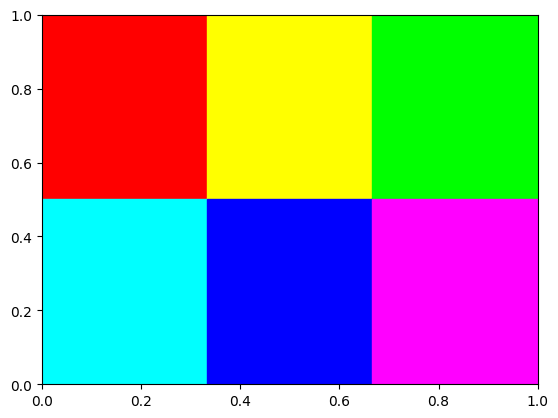

MovieWriter ffmpeg unavailable; using Pillow instead.


IndexError: list index out of range

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
from matplotlib.colors import hsv_to_rgb

def animate_colors(colors_grid, duration, frames_per_second):
    rows = len(colors_grid)
    columns = len(colors_grid[0])
    # Create a figure and axis
    fig, ax = plt.subplots()

    # Set axis limits
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

    rectangles = []
    for i in range(rows*columns):
        rect = plt.Rectangle(((i%columns)/columns, 1-(i//columns+1)/rows), 1/columns, 1/rows, color=hsv_to_rgb(colors_grid[i//columns][i%columns]))
        rectangles.append(rect)
        ax.add_patch(rect)
    
    def update(frame):
        for i in range(rows*columns):
            color_index = int(frame // (frames_per_second * duration / len(colors_grid[i//columns][i%columns])))
            next_color_index = (color_index + 1) % len(colors_grid[i//columns][i%columns])
            color_weight = frame % (frames_per_second * duration / len(colors_grid[i//columns][i%columns])) / (frames_per_second * duration / len(colors_grid[i//columns][i%columns]))
            color = hsv_to_rgb((colors_grid[i//columns][i%columns][color_index][0] + (colors_grid[i//columns][i%columns][next_color_index][0] - colors_grid[i//columns][i%columns][color_index][0]) * color_weight,
    colors_grid[i//columns][i%columns][color_index][1] + (colors_grid[i//columns][i%columns][next_color_index][1] - colors_grid[i//columns][i%columns][color_index][1]) * color_weight,
    colors_grid[i//columns][i%columns][color_index][2] + (colors_grid[i//columns][i%columns][next_color_index][2] - colors_grid[i//columns][i%columns][color_index][2]) * color_weight))
            rectangles[i].set_color(color)

    # Create animation using the
    ani = FuncAnimation(fig, update, frames=np.linspace(0, frames_per_second * duration - 1, frames_per_second * duration), repeat=False)
    plt.show()
    ani.save('bioanim.gif')    


colors_grid = [[[0, 1, 1], [60/360, 1, 1], [120/360, 1, 1]], [[180/360, 1, 1], [240/360, 1, 1], [300/360, 1, 1]]]
animate_colors(colors_grid, 5, 60)

FileNotFoundError: [WinError 2] The system cannot find the file specified

Error in callback <function _draw_all_if_interactive at 0x000001C226D33EE0> (for post_execute):


TypeError: 'float' object is not subscriptable

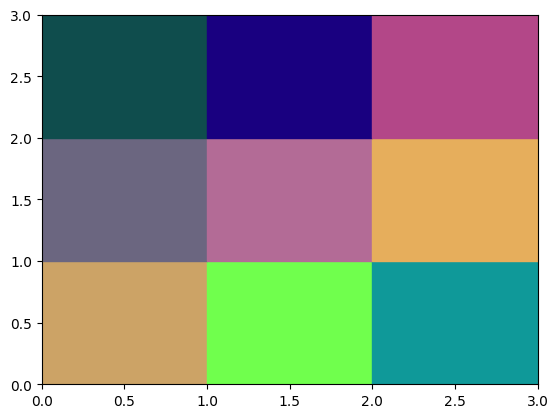

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation
from matplotlib.animation import FuncAnimation
from matplotlib.colors import hsv_to_rgb
from IPython import display

def animate_colors(color_grid, duration, frames_per_second, filename='test'):
    # Create a figure and axis
    fig, ax = plt.subplots()

    # Set axis limits
    ax.set_xlim(0, len(color_grid[0]))
    ax.set_ylim(0, len(color_grid))

    # Create a list of rectangular patches
    rects = []
    for i in range(len(color_grid)):
        row = []
        for j in range(len(color_grid[i])):
            rect = plt.Rectangle((j, i), 1, 1, color=hsv_to_rgb(color_grid[i][j]))
            ax.add_patch(rect)
            row.append(rect)
        rects.append(row)

    def update(frame):
        color_index = int(frame // (frames_per_second * duration / len(color_grid)))
        next_color_index = (color_index + 1) % len(color_grid)
        color_weight = frame % (frames_per_second * duration / len(color_grid)) / (frames_per_second * duration / len(color_grid))
        for i in range(len(color_grid)):
            for j in range(len(color_grid[i])):
                color = hsv_to_rgb((color_grid[color_index][i][j][0] + (color_grid[next_color_index][i][j][0] - color_grid[color_index][i][j][0]) * color_weight,
                                    color_grid[color_index][i][j][1] + (color_grid[next_color_index][i][j][1] - color_grid[color_index][i][j][1]) * color_weight,
                                    color_grid[color_index][i][j][2] + (color_grid[next_color_index][i][j][2] - color_grid[color_index][i][j][2]) * color_weight))
                rects[i][j].set_color(color)

    # Create animation using the update function
    ani = FuncAnimation(fig, update, frames=np.linspace(0, frames_per_second * duration - 1, frames_per_second * duration), repeat=True)
    #plt.show()
    #f = r"/animation.mp4" 
    writervideo = matplotlib.animation.FFMpegWriter(fps=60)
    ani.save('test.mov', writer=writervideo)
    # embedding for the video
    #html = display.HTML(ani)
    
    # draw the animation
    #display.display(html)
    #plt.close()
    print('ready to save')
    #ani.save('{}.gif'.format(filename))

color_grid = [[(0.1, 0.5, 0.8), (0.3, 0.7, 1.0), (0.5, 0.9, 0.6)],
              [(0.7, 0.2, 0.5), (0.9, 0.4, 0.7), (0.1, 0.6, 0.9)],
              [(0.5, 0.8, 0.3), (0.7, 1.0, 0.5), (0.9, 0.6, 0.7)]]

animate_colors(color_grid, 5, 30, filename='grid_animation')


In [15]:
import colorsys

def average_complementarity(colors):
    complementarity_sum = 0
    for color in colors:
        hsv_color = colorsys.rgb_to_hsv(*color)
        complement_hue = (hsv_color[0] + 0.5) % 1 # Find complement hue by adding 0.5 to the hue value
        complementarity = abs(complement_hue - hsv_color[0]) # Calculate complementarity by taking the absolute difference between the complement hue and the original hue
        complementarity_sum += complementarity
    return complementarity_sum / len(colors)


def average_analogous(colors):
    hues = [color[0] for color in colors]
    avg_diff = sum([min(abs(hues[i+1]-hues[i]), 1-abs(hues[i+1]-hues[i])) for i in range(len(hues)-1)])/(len(hues)-1)
    return avg_diff


import numpy as np

def average_monochromatism(colors):
    hues = [color[0] for color in colors]
    avg_hue = sum(hues) / len(hues)
    hue_diversity = sum([abs(hue - avg_hue) for hue in hues]) / len(hues)
    
    saturations = [color[1] for color in colors]
    avg_saturation = sum(saturations) / len(saturations)
    saturation_diversity = sum([abs(saturation - avg_saturation) for saturation in saturations]) / len(saturations)
    
    luminances = [color[2] for color in colors]
    avg_luminance = sum(luminances) / len(luminances)
    luminance_diversity = sum([abs(luminance - avg_luminance) for luminance in luminances]) / len(luminances)
    
    return (1 - hue_diversity) * (1 - (saturation_diversity + luminance_diversity) / 2)

import colorsys

def average_triadic_value(colors):
    total_triadic_value = 0
    for color in colors:
        hue = color[0]
        triadic_value = min(abs(hue - (color[0] + 120) % 360), abs(hue - (color[0] + 240) % 360)) / 180
        total_triadic_value += triadic_value
    return total_triadic_value / len(colors)

def color_harmony(colors):
    # Define the weights for each color harmony type
    complementarity_weight = 0.25
    analogous_weight = 0.25
    monochromatism_weight = 0.25
    triadic_weight = 0.25
    
    # Compute the average complementarity of the colors
    avg_complementarity = average_complementarity(colors)
    
    # Compute the average analogous value of the colors
    avg_analogous = average_analogous(colors)
    
    # Compute the average monochromatism of the colors
    avg_monochromatism = average_monochromatism(colors)
    
    # Compute the average triadic value of the colors
    avg_triadic = average_triadic_value(colors)
    
    # Compute the overall color harmony score
    harmony_score = complementarity_weight * avg_complementarity + analogous_weight * avg_analogous + monochromatism_weight * avg_monochromatism + triadic_weight * avg_triadic
    
    return harmony_score


colors = [(130, 0, 0), (255, 200, 0), (250, 0, 255)] # red, green, blue
mid_harm = [ (255, 165, 0), (255, 0, 0), (0, 255, 0) ]
high_harm = [ (255, 192, 203), (250, 235, 215), (245, 245, 245) ]
low_harm = [ (255, 0, 0), (0, 255, 0), (0, 0, 255) ]
score = color_harmony(low_harm)
print(score)




3123.236111111111


In [18]:
import math

def color_triangle_angles(colors):
    angles = []
    for i in range(3):
        hue1 = colors[i][0]
        hue2 = colors[(i+1)%3][0]
        hue_diff = abs(hue1 - hue2)
        angle = min(hue_diff, 360 - hue_diff)
        angles.append(angle)
    return angles

triadic = [ (0, 1, 1), (120, 1, 1), (240, 1, 1) ]
rnd = [(10,0.5,0.8), (85, 0.9, 0.7), (190, 0.6, 0.4)]

color_triangle_angles(rnd)

[75, 105, 180]

### Visualizing scales of the periodic table of elements 

    EMISSION SPECTRUM OF ELEMENTS

    hydrogen_nm = [656.3, 486.1, 434, 410.1, 397]
    helium_nm = [667.8, 587.5, 501.5, 492.1, 471.3, 447.1, 402.6]
    mercury_nm = [623.4, 615.2, 579, 577, 546.1, 502.5, 435.8, 407.8, 404.7]